Easy to read article about calibration: http://fastml.com/classifier-calibration-with-platts-scaling-and-isotonic-regression/

In [40]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from scipy import stats
from sklearn import datasets
#from sklearn.naive_bayes import GaussianNB
#from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.cross_validation import cross_val_predict
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_validation import *
from sklearn.model_selection import ShuffleSplit
#from sklearn.ensemble import AdaBoostRegressor
# from sklearn.ensemble import FairBoostRegressor
#from sklearn.tree import DecisionTreeRegressor
# from sklearn.model_selection import train_test_split
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import KFold
%matplotlib inline
%precision %.2f
pd.options.display.float_format = '{:,.2f}'.format
from random import shuffle
import math

In [50]:
#load data
X = pickle.load( open( "data/processed/x.p", "rb" ) )
y = pickle.load( open( "data/processed/y.p", "rb" ) )
g = pickle.load( open( "data/processed/g.p", "rb" ) )
g = np.nan_to_num(g)
g0 = np.nan_to_num([i for i,x in enumerate(g) if x==0])
g1 = np.nan_to_num([i for i,x in enumerate(g) if x==1])
print(len(g0))
print(len(g1))

75
67


In [5]:
#Error metrics

#summary of deviation measures - relates to precision/accuracy?
# https://en.wikipedia.org/wiki/Deviation_(statistics)#Unsigned_or_absolute_deviation
#https://en.wikipedia.org/wiki/Mean_signed_deviation
#signed absolute deviation ?
# https://en.wikipedia.org/wiki/Average_absolute_deviation
#average absolute deviation

def get_ae(vals):
    return np.sum([math.fabs(x[0]-x[1]) for x in vals])

def get_mae(vals):
    m = np.sum([math.fabs(x[0]-x[1]) for x in vals])
    return m/len(vals)


def get_se(vals):
    return np.sum([math.pow(x[0]-x[1], 2) for x in vals])
    
def get_mse(vals):
    m = np.sum([math.pow(x[0]-x[1], 2) for x in vals])
    return m/len(vals)

#overestimate
def get_oe(vals):
    return np.sum([max(0,x[0]-x[1]) for x in vals])

def get_moe(vals):
    m = np.sum([max(0,x[0]-x[1]) for x in vals])
    return m/len(vals)

#underestimate
def get_ue(vals):
    return np.sum([min(0,x[0]-x[1]) for x in vals])

def get_mue(vals):
    m = np.sum([min(0,x[0]-x[1]) for x in vals])
    return m/len(vals)

def get_spear(vals):
    a=[x[0] for x in vals]
    b=[x[1] for x in vals]
    return stats.spearmanr(a,b)[0]

error_functs = [get_ae, get_mae, get_se, get_mse, get_oe, get_moe, get_ue, get_mue]
##### BIN ERRORS: ###########

def get_bin_width(data, n):
    return (data.max()-data.min())/(n+1)    

def get_error_binned_eq_depth_by_group(points, nbins, error=get_mse):
    mse = []
    kf = KFold(n_splits=nbins, shuffle=True, random_state=1)
    for rest, bin in kf.split(points):
        vals = [points.iloc[i] for i in bin]
        mse.append(error(vals))
    return mse

def plot_binned_error(df, error=get_mse):
    indices =np.arange(df.shape[0])
    #Calculate optimal width
    width = 0.3

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.bar(indices-width,df[df.columns[0]],width,color='b',label='-Ymin')
    ax.bar(indices,df[df.columns[1]],width,color='r',label='Ymax')
    ax.set_xlim(left=-1,right=len(df))
    ax.set_ylim([0,1])
    ax.set_xlabel('Bin')
    ax.set_ylabel(error.__name__)
    plt.show()
    
def recomputeBins_no_groups(y_predict, nbins):
        #g0 has indexes of objects in X
        # get indexes of sorted predictions for group
        sorted = np.argsort(y_predict)
        binSize=int(np.ceil(float(len(y_predict))/nbins))
        bins=[]
        b=[]
        i=0
        j=binSize-1
        for n in range(nbins):
            k=int(min(j,len(sorted)-1))
            bins.append(sorted0[i:k])
            i+=binSize
            j+=binSize
           
        return bins

def get_calibration_error(y_pred, y, nbins):    
    error_vect=np.abs(y_pred - y)
    e0=[np.sum([error_vect[i] for i in b]) for b in bins0]
    bin_error = np.subtract(e0, e1)
    return np.mean(np.abs(bin_error))

def recomputeBins(y_predict, g0, g1, nbins):
        sorted0 = np.argsort([y_predict[x] for x in g0])
        binSize=int(np.ceil(float(len(g0))/nbins))
        bins0=[]
        b=[]
        i=0
        j=binSize-1
        for n in range(nbins):
            k=int(min(j,len(sorted0)-1))
            bins0.append([g0[x] for x in sorted0[i:k]])
            i+=binSize
            j+=binSize
        sorted1 = np.argsort([y_predict[x] for x in g1])
        binSize=int(np.ceil(float(len(g1))/nbins))
        bins1=[]
        b=[]
        i=0
        j=binSize-1
        for n in range(nbins):
            k=int(min(j,len(sorted0)-1))
            bins1.append([g1[x] for x in sorted1[i:k]])
            i+=binSize
            j+=binSize
        return bins0,bins1
    
def get_fair_error(y_pred, y, g0, g1, nbins):    
    bins0,bins1  = recomputeBins(y_pred, g0, g1, nbins)
    error_vect=np.abs(y_pred - y)
    e0=[np.sum([error_vect[i] for i in b]) for b in bins0]
    e1=[np.sum([error_vect[i] for i in b]) for b in bins1]
    bin_error = np.subtract(e0, e1)
    return np.mean(np.abs(bin_error))

In [54]:
def get_errors(y_hat, y, g, nbins):
    results = pd.DataFrame()
    results['pred'] = y_hat
    results['y'] = y
    results['g'] = g
    results = results.sort_values('pred')
    results0 = results[results['g']==0]
    results1 = results[results['g']==1]
    errors = pd.DataFrame()
    errors['mse0'] = get_error_binned_eq_depth_by_group(results0, 
                                                        nbins, error=get_mse)
    errors['mse1'] = get_error_binned_eq_depth_by_group(results1, 
                                                        nbins, error=get_mse)
    errors['bin_mse_diff']=errors['mse0']-errors['mse1']
    errors['ae0'] = get_error_binned_eq_depth_by_group(results0, 
                                                      nbins, error=get_ae)
    errors['ae1'] = get_error_binned_eq_depth_by_group(results1, 
                                                        nbins, error=get_ae)
    errors['bin_ae_diff']=errors['ae0']-errors['ae1']
    errors['oe0'] = get_error_binned_eq_depth_by_group(results0, 
                                                      nbins, error=get_oe)
    errors['oe1'] = get_error_binned_eq_depth_by_group(results1, 
                                                        nbins, error=get_oe)
    errors['bin_oe_diff']=errors['oe0']-errors['oe1']
    errors['ue0'] = get_error_binned_eq_depth_by_group(results0, 
                                                      nbins, error=get_ue)
    errors['ue1'] = get_error_binned_eq_depth_by_group(results1, 
                                                        nbins, error=get_ue)
    errors['bin_ue_diff']=errors['ue0']-errors['ue1']
    errors['spear0'] = get_error_binned_eq_depth_by_group(results0, 
                                                      nbins, error=get_spear)
    errors['spear1'] = get_error_binned_eq_depth_by_group(results1, 
                                                        nbins, error=get_spear)
    errors['bin_spear_diff']=errors['spear0']-errors['spear1']
    return errors

In [150]:
# 3 fold cross validation,for each split use 25% of the training data for calibration

cv_errors ={}
kf = KFold(n_splits=3, shuffle=True, random_state=1)
i=0
for train_index, test_index in kf.split(X):
    X_train_full=X[train_index]
    X_test=X[test_index]

    y_train_full=y[train_index]
    y_test=y[test_index]

    g_train_full=g[train_index]
    g_test=g[test_index]
    
    ss = ShuffleSplit(n_splits=1, test_size=0.5, random_state=0)
    for tr, cal in ss.split(X_train_full): #only 1
        X_calibrate=X_train_full[cal]
        X_train=X_train_full[tr]
        
        y_calibrate=y_train_full[cal]
        y_train=y_train_full[tr]
        
        g_calibrate=g_train_full[cal] 
        g_train=g_train_full[tr]
        
    
    print("training", len(X_train[g_train==0.]))
    print("training", len(X_train[g_train==1.]))
    print("calibration", len(X_calibrate[g_calibrate==0.]))
    print("calibration", len(X_calibrate[g_calibrate==1.]))
    print("testing", len(g_test[g_test==0.]))
    print("testing", len(g_test[g_test==1.]))

    y_pred_baseline = get_baseline_predictions(X_train, y_train, X_test)

    y_pred_cal = get_calibrated_predictions(X_train, y_train, X_calibrate, y_calibrate, X_test)
    
    y_test0 = y_test[g_test ==0.]
    print()
    y_test1 = y_test[g_test ==1.]
    y_test_all = np.append(y_test0, y_test1)
    
    g_test0 = g_test[g_test ==0.]
    g_test1 = g_test[g_test ==1.]
    g_test_all = np.append(g_test0, g_test1)
    
    y_pred0, y_pred1 = get_groupwise_calibrated_predictions(X_train, y_train, X_calibrate, 
                                                            y_calibrate, g_calibrate, X_test, g_test)
    y_pred_all = np.append(y_pred0, y_pred1)
    
    nbins=3
    baseline_errors = get_errors(y_pred_baseline, y_test, g_test, nbins)
    calibrate_errors = get_errors(y_pred_cal, y_test, g_test, nbins)
    cal_by_group_errors = get_errors(y_pred_all, y_test_all, g_test_all, nbins)
    
    cv_errors[i] = [baseline_errors, calibrate_errors, cal_by_group_errors]
    i+=1

#     print(get_errors(y_pred_baseline, y_test, g_test, nbins))
#     print(get_errors(y_pred_cal, y_test, g_test, nbins))
#     print(get_errors(y_pred_all, y_test_all, g_test_all, nbins))
    
#     print("Baseline mse: ", mean_squared_error(y_pred_baseline, y_test))
#     print("Calibrate mse: ", mean_squared_error(y_pred_cal, y_test))
#     print("Calibrate by groups mse: ", mean_squared_error(y_pred_all, y_test_all))

#     print("Baseline spearman: ", stats.spearmanr(y_pred_baseline, y_test))
#     print("Calibrate spearman: ", stats.spearmanr(y_pred_cal, y_test))
#     print("Calibrate by groups spearman: ", stats.spearmanr(y_pred_all, y_test_all))
    

training 22
training 25
calibration 23
calibration 24
testing 30
testing 18

training 27
training 20
calibration 27
calibration 21
testing 21
testing 26

training 24
training 23
calibration 27
calibration 21
testing 24
testing 23



In [151]:
cv_errors

{0: [   mse0  mse1  bin_mse_diff  ae0  ae1  bin_ae_diff  oe0  oe1  bin_oe_diff  \
  0  0.21  0.06          0.14 4.11 1.29         2.82 0.98 0.44         0.54   
  1  0.07  0.20         -0.13 2.19 2.28        -0.09 0.78 0.74         0.05   
  2  0.23  0.08          0.15 4.27 1.51         2.75 1.00 0.60         0.39   
  
      ue0   ue1  bin_ue_diff  spear0  spear1  bin_spear_diff  
  0 -3.12 -0.85        -2.28    0.81    0.93           -0.12  
  1 -1.41 -1.54         0.13    0.92    0.94           -0.02  
  2 -3.27 -0.91        -2.36    0.91    0.71            0.20  ,
     mse0  mse1  bin_mse_diff  ae0  ae1  bin_ae_diff  oe0  oe1  bin_oe_diff  \
  0  0.12  0.13         -0.01 2.90 2.15         0.76 1.59 1.29         0.31   
  1  0.19  0.15          0.03 3.45 1.83         1.62 2.34 1.60         0.74   
  2  0.21  0.10          0.11 3.69 1.52         2.18 1.35 0.73         0.63   
  
      ue0   ue1  bin_ue_diff  spear0  spear1  bin_spear_diff  
  0 -1.31 -0.86        -0.45    0.84    0.9

In [152]:
b = pd.concat([cv_errors[0][0][['bin_mse_diff','bin_oe_diff','bin_ue_diff', 'bin_spear_diff']].abs().sum(),
           cv_errors[1][0][['bin_mse_diff','bin_oe_diff','bin_ue_diff', 'bin_spear_diff']].abs().sum(),
           cv_errors[2][0][['bin_mse_diff','bin_oe_diff','bin_ue_diff', 'bin_spear_diff']].abs().sum()], axis=1).transpose()
c = pd.concat([cv_errors[0][1][['bin_mse_diff','bin_oe_diff','bin_ue_diff', 'bin_spear_diff']].abs().sum(),
           cv_errors[1][1][['bin_mse_diff','bin_oe_diff','bin_ue_diff', 'bin_spear_diff']].abs().sum(),
           cv_errors[2][1][['bin_mse_diff','bin_oe_diff','bin_ue_diff', 'bin_spear_diff']].abs().sum()], axis=1).transpose()
cg = pd.concat([cv_errors[0][2][['bin_mse_diff','bin_oe_diff','bin_ue_diff', 'bin_spear_diff']].abs().sum(),
           cv_errors[1][2][['bin_mse_diff','bin_oe_diff','bin_ue_diff', 'bin_spear_diff']].abs().sum(),
           cv_errors[2][2][['bin_mse_diff','bin_oe_diff','bin_ue_diff', 'bin_spear_diff']].abs().sum()], axis=1).transpose()

In [153]:
b.sum()

bin_mse_diff     0.62
bin_oe_diff      3.37
bin_ue_diff      8.83
bin_spear_diff   0.53
dtype: float64

In [154]:
c.sum()

bin_mse_diff     0.55
bin_oe_diff      5.08
bin_ue_diff      8.27
bin_spear_diff   0.82
dtype: float64

In [155]:
cg.sum()

bin_mse_diff     0.69
bin_oe_diff      4.92
bin_ue_diff      7.41
bin_spear_diff   0.63
dtype: float64

In [43]:
def get_baseline_predictions(X_train, y_train, X_test):
    
    lr = linear_model.LinearRegression()
    lr.fit(X_train, y_train)
    
    return lr.predict(X_test)  

In [42]:
def get_calibrated_predictions(X_train, y_train, X_cal, y_cal, X_test):
    
    lr = linear_model.LinearRegression()
    lr.fit(X_train, y_train)
    
    y_pred = lr.predict(X_cal) 
    ir = IsotonicRegression( out_of_bounds = 'clip' )
    ir.fit(y_pred, y_cal)
    
    return ir.transform(lr.predict(X_test))   

In [46]:
def get_groupwise_calibrated_predictions(X_train, y_train, X_cal, y_cal, g_cal, X_test, g_test):
    
    lr = linear_model.LinearRegression()
    lr.fit(X_train, y_train)
    
    y_pred = lr.predict(X_cal) 
    y_pred0 = y_pred[g_cal ==0.]
    y_pred1 = y_pred[g_cal ==1.]
    y_cal0 = y_cal[g_cal ==0.]
    y_cal1 = y_cal[g_cal ==1.]
    X_test0 = X_test[g_test ==0.]
    X_test1 = X_test[g_test ==1.]
    ir0 = IsotonicRegression( out_of_bounds = 'clip' )
    ir0.fit(y_pred0, y_cal0)
    ir1 = IsotonicRegression( out_of_bounds = 'clip' )
    ir1.fit(y_pred1, y_cal1)
    
    y_pred0 = ir0.transform(lr.predict(X_test0))  
    y_pred1 = ir1.transform(lr.predict(X_test1))
    return y_pred0, y_pred1

In [180]:
#calibrate by groups
y_test0 = y_test[g_test==0.]
y_test1 = y_test[g_test==1.]
y_hat_c0 = [x for i,x in enumerate(y_hat_calibrate) if g_calibrate[i]==0]
y_hat_c1 = [x for i,x in enumerate(y_hat_calibrate) if g_calibrate[i]==1]
y_c0 = [x for i,x in enumerate(y_calibrate) if g_calibrate[i]==0]
y_c1 = [x for i,x in enumerate(y_calibrate) if g_calibrate[i]==1]
yhb0 = [x for i,x in enumerate(y_hat_test_baseline) if g_test[i]==0]
yhb1 = [x for i,x in enumerate(y_hat_test_baseline) if g_test[i]==1]


In [181]:
ir0 = ir.fit(y_hat_c0, y_c0)
ir1 = ir.fit(y_hat_c1, y_c1)
y_hat_test_c0 = ir0.transform(yhb0)
y_hat_test_c1 = ir1.transform(yhb1)
y_hat_test_c_all = np.append(y_hat_test_c0, y_hat_test_c1)
y_test_all = np.append(y_test0, y_test1)
g_test0 = np.nan_to_num([x for x in g_test if x==0])
g_test1 = np.nan_to_num([x for x in g_test if x==1])
g_test_all = np.append(g_test0, g_test1)

In [6]:
nbins=5
bins0, bins1 = recomputeBins(y_hat_test_calibrate,  
                              g0_calibrate, g1_calibrate, nbins)
print(bins0)
print(bins1)


NameError: name 'y_hat_test_calibrate' is not defined

In [182]:
print(len(y_test_all))
print(len(y_hat_test_c_all ))

93
93


In [193]:
print("Baseline: ", mean_squared_error(y_hat_test_baseline, y_test))
print("Calibrate: ", mean_squared_error(y_hat_test_calibrate, y_test))
print("Calibrate by groups: ", mean_squared_error(y_hat_test_c_all, y_test_all))

print("Baseline spearman: ", stats.spearmanr(y_hat_test_baseline, y_test))
print("Calibrate spearman: ", stats.spearmanr(y_hat_test_calibrate, y_test))
print("Calibrate by groups spearman: ", stats.spearmanr(y_hat_test_c_all, y_test_all))


Baseline:  0.192368091238
Calibrate:  0.191341254514
Calibrate by groups:  0.178985702403
Baseline spearman:  SpearmanrResult(correlation=0.9156122704404589, pvalue=8.8986318315555927e-38)
Calibrate spearman:  SpearmanrResult(correlation=0.90386908674635402, pvalue=2.557628804730265e-35)
Calibrate by groups spearman:  SpearmanrResult(correlation=0.91449393640068988, pvalue=1.5792552755417326e-37)


In [192]:
# baseline_errors = get_errors(y_hat_test_baseline, y_test, g_test, nbins)
# calibrate_errors = get_errors(y_hat_test_calibrate, y_test, g_test, nbins)
# cal_by_group_errors = get_errors(y_hat_test_c_all, y_test_all, g_test_all, nbins)

baseline_errors = get_errors(y_hat_test_baseline, y_test, g_test, nbins)
calibrate_errors = get_errors(y_hat_test_calibrate, y_test, g_test, nbins)
cal_by_group_errors = get_errors(y_hat_test_c_all, y_test_all, g_test_all, nbins)

In [185]:
baseline_errors

,mse0,mse1,bin_mse_diff,ae0,ae1,bin_ae_diff,oe0,oe1,bin_oe_diff,ue0,ue1,bin_ue_diff,spear0,spear1,bin_spear_diff
0,0.16,0.39,-0.22,3.43,5.00,-1.57,0.60,1.11,-0.51,-2.83,-3.88,1.05,0.85,0.87,-0.01
1,0.23,0.16,0.07,3.92,2.57,1.35,1.20,0.53,0.67,-2.72,-2.04,-0.68,0.70,0.92,-0.22
2,0.27,0.19,0.08,3.91,3.18,0.74,0.47,0.97,-0.50,-3.44,-2.21,-1.23,0.97,0.87,0.10
3,0.20,0.09,0.11,3.17,2.08,1.09,1.82,1.14,0.68,-1.36,-0.95,-0.41,0.87,0.98,-0.12
4,0.11,0.09,0.02,2.47,2.25,0.21,0.93,0.65,0.28,-1.53,-1.60,0.07,0.89,0.87,0.02


In [186]:
calibrate_errors

,mse0,mse1,bin_mse_diff,ae0,ae1,bin_ae_diff,oe0,oe1,bin_oe_diff,ue0,ue1,bin_ue_diff,spear0,spear1,bin_spear_diff
0,0.17,0.09,0.08,3.28,2.49,0.79,2.49,1.34,1.15,-0.79,-1.15,0.36,0.92,0.87,0.05
1,0.28,0.40,-0.12,4.25,4.72,-0.47,2.99,2.30,0.69,-1.25,-2.42,1.17,0.81,0.53,0.27
2,0.09,0.15,-0.06,1.87,2.30,-0.43,0.23,1.20,-0.97,-1.64,-1.09,-0.54,0.97,0.91,0.06
3,0.27,0.10,0.17,3.50,2.35,1.14,1.03,1.30,-0.27,-2.47,-1.05,-1.42,0.90,0.93,-0.03
4,0.18,0.19,-0.01,2.90,3.28,-0.38,0.32,1.62,-1.29,-2.58,-1.66,-0.92,0.91,0.96,-0.05


In [187]:
cal_by_group_errors

,mse0,mse1,bin_mse_diff,ae0,ae1,bin_ae_diff,oe0,oe1,bin_oe_diff,ue0,ue1,bin_ue_diff,spear0,spear1,bin_spear_diff
0,0.17,0.17,0.00,3.12,3.41,-0.29,1.85,2.34,-0.49,-1.27,-1.07,-0.20,0.85,0.92,-0.07
1,0.23,0.14,0.09,3.86,2.62,1.24,3.61,1.28,2.33,-0.25,-1.34,1.09,0.84,0.90,-0.07
2,0.13,0.22,-0.10,2.74,3.38,-0.63,1.28,2.76,-1.48,-1.46,-0.62,-0.84,0.97,0.92,0.05
3,0.34,0.17,0.17,4.37,3.00,1.37,2.58,2.05,0.53,-1.79,-0.95,-0.84,0.88,0.92,-0.04
4,0.06,0.16,-0.10,2.03,2.45,-0.42,1.16,2.00,-0.84,-0.87,-0.45,-0.42,0.90,0.87,0.03


In [191]:
print("baseline fair error mse: ", baseline_errors['bin_mse_diff'].abs().mean())
print("baseline fair error ae: ", baseline_errors['bin_ae_diff'].abs().mean())
print("baseline fair error spear: ", baseline_errors['bin_spear_diff'].abs().mean())

print("calibration fair error mse: ", calibrate_errors['bin_mse_diff'].abs().mean())
print("calibration fair error ae: ", calibrate_errors['bin_ae_diff'].abs().mean())
print("calibration fair error aspear: ", calibrate_errors['bin_spear_diff'].abs().mean())

print("cal by group fair error mse: ", cal_by_group_errors['bin_mse_diff'].abs().mean())
print("cal by group fair error ae: ", cal_by_group_errors['bin_ae_diff'].abs().mean())
print("cal by group fair error spear: ", cal_by_group_errors['bin_spear_diff'].abs().mean())

baseline fair error mse:  0.1012496010089466
baseline fair error ae:  0.9923247087413823
baseline fair error spear:  0.09325186165846848
calibration fair error mse:  0.08714470247965984
calibration fair error ae:  0.6420802961981933
calibration fair error aspear:  0.09426302903732034
cal by group fair error mse:  0.09109816561742294
cal by group fair error ae:  0.7903676579668524
cal by group fair error spear:  0.050241195715621446


Absolute


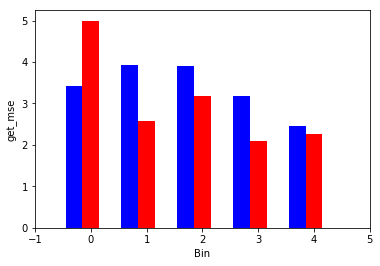

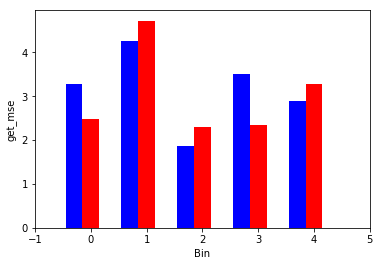

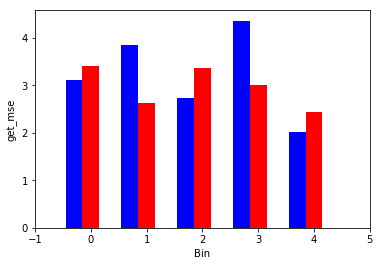

Overestimation


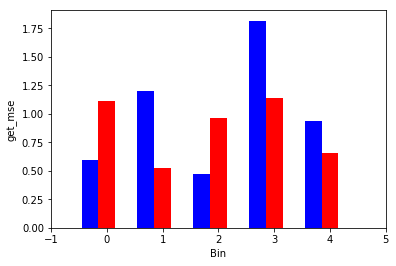

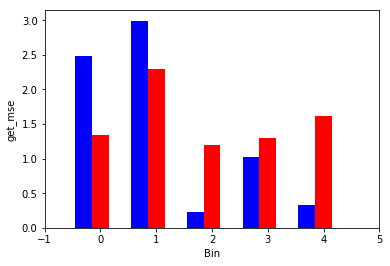

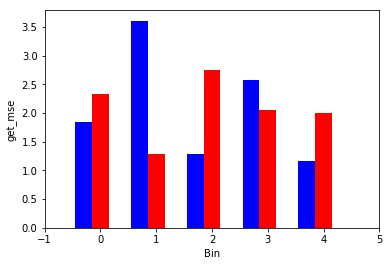

Underestimation


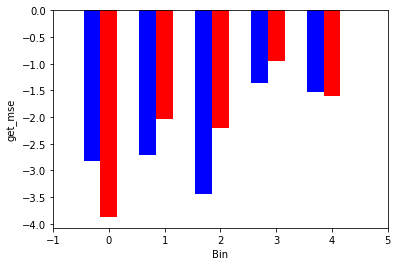

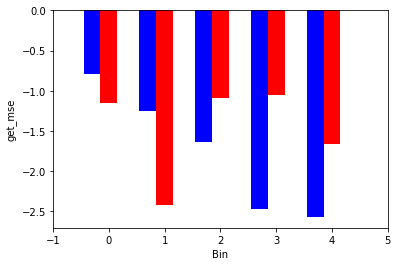

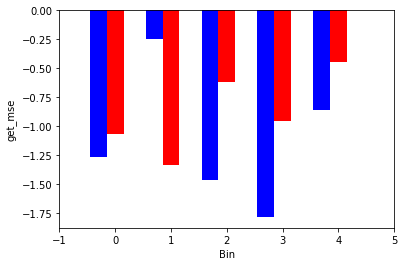

Spear


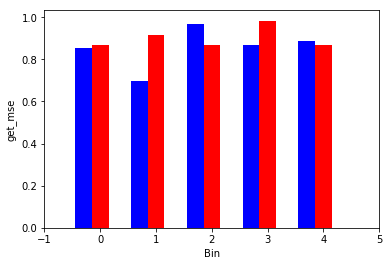

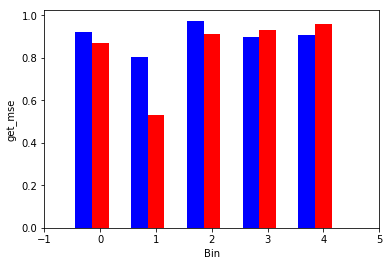

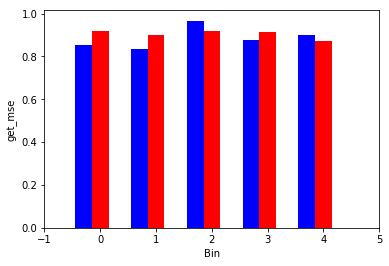

In [197]:
print("Absolute")
plot_error(baseline_errors, 3,4)
plot_error(calibrate_errors, 3,4)
plot_error(cal_by_group_errors,3,4)
print("Overestimation")
plot_error(baseline_errors, 6,7)
plot_error(calibrate_errors, 6,7)
plot_error(cal_by_group_errors,6,7)
print("Underestimation")
plot_error(baseline_errors, 9,10)
plot_error(calibrate_errors, 9,10)
plot_error(cal_by_group_errors,9,10)
print("Spear")
plot_error(baseline_errors, 12,13)
plot_error(calibrate_errors, 12,13)
plot_error(cal_by_group_errors,12,13)

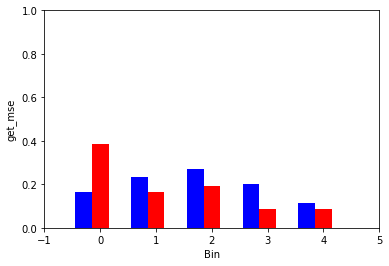

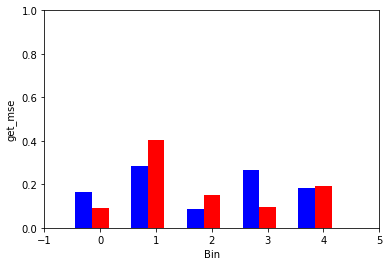

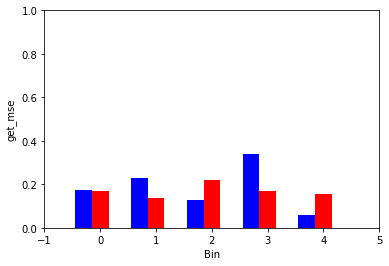

In [189]:
plot_binned_error(baseline_errors)
plot_binned_error(calibrate_errors)
plot_binned_error(cal_by_group_errors)

In [196]:
def plot_error(df, i, j, error=get_mse):
    indices =np.arange(df.shape[0])
    #Calculate optimal width
    width = 0.3

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.bar(indices-width,df[df.columns[i]],width,color='b',label='-Ymin')
    ax.bar(indices,df[df.columns[j]],width,color='r',label='Ymax')
    ax.set_xlim(left=-1,right=len(df))
#     ax.set_ylim([0,1])
    ax.set_xlabel('Bin')
    ax.set_ylabel(error.__name__)
    plt.show()

In [134]:
#kf = KFold(n_splits=2, shuffle=True, random_state=1)

#nbins = 10

In [135]:
# for train_index, test_index, in kf.split(X):
#     dt = DecisionTreeRegressor(max_depth=4)
#     dt.fit(X[train_index],y[train_index])
#     dt_pred = dt.predict(X[test_index])
#     clf_isotonic = CalibratedRegressor(dt, cv="prefit", method='isotonic')
#     clf_isotonic.fit(X[train_index], y[train_index])
#     prob_pos_isotonic = clf_isotonic.predict_proba(X_test)[:, 1]
#     print('\n decision tree error: ', mean_squared_error(dt_pred, y[test_index]))

#     g0 = [i for i,x in enumerate(g[test_index]) if x==0]
#     g1 = [i for i,x in enumerate(g[test_index]) if x==1]
#     bins0,bins1  = recomputeBins(dt_pred, g0, g1, nbins)
#     error_vect=np.abs(dt_pred - y[test_index])
#     e0=[np.sum([error_vect[i] for i in b]) for b in bins0]
#     e1=[np.sum([error_vect[i] for i in b]) for b in bins1]
#     bin_error = np.subtract(e0, e1)
#     print("dt fair error: ", np.mean(np.abs(bin_error)))

#     ### PLOTTING ###
#     results = pd.DataFrame()
#     results['pred'] = dt_pred
#     results['y'] = y[test_index]
#     results['g'] = g[test_index]
#     results = results.sort_values('pred')
#     results0 = results[results['g']==0]
#     print ("group0: ", results0.shape)
#     results1 = results[results['g']==1]
#     print ("group1: ", results1.shape)

#     mse_df_depth = pd.DataFrame()
#     mse_df_depth['mse0'] = get_error_binned_eq_depth_by_group(results0, nbins, error=get_mse)
#     mse_df_depth['mse1'] = get_error_binned_eq_depth_by_group(results1, nbins, error=get_mse)
#     plot_binned_error(mse_df_depth)

TODO:
    Not producing any consistent results
    Try different ways of updating the weights bin-wise
    is error being computed as mse? investigate error_vect
    read up on non-differentiable error in boosting. Are we just jumping around?
    try plotting change in bin_error over iterations